# Setup
- [link dataset](https://www.kaggle.com/datasets/sujaykapadnis/emotion-recognition-dataset/data?select=dataset)

In [1]:
!pip install -q opendatasets
!pip install -q split-folders

### import libraries

In [71]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Input, GlobalAveragePooling2D
import numpy as np
import matplotlib.pyplot as plt
import pathlib, zipfile, os, splitfolders
import opendatasets as od
import pandas as pd
import seaborn as sns

### download dataset

In [3]:
od.download('https://www.kaggle.com/datasets/sujaykapadnis/emotion-recognition-dataset/data?select=dataset')

100%|██████████| 1.98G/1.98G [00:24<00:00, 88.0MB/s]


### split data into train and val

In [4]:
PATH = '/content/emotion-recognition-dataset/dataset'

In [5]:
import shutil
remove_folder = ['Ahegao', 'Angry', 'Surprise']

for folder in remove_folder:
  folder_path = os.path.join(PATH, folder)
  if os.path.exists(folder_path):
    shutil.rmtree(folder_path)

In [6]:
splitfolders.ratio(PATH, output='/content/project', seed=64, ratio=(0.8, 0.2))
train_dir = '/content/project/train'
validation_dir = '/content/project/val'

Copying files: 11701 files [00:09, 1278.30 files/s]


### define variables

In [63]:
BATCH_SIZE = 64
IMG_SIZE = (224,224)

### create tf dataset

In [66]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=100,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 9360 files belonging to 3 classes.


In [67]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    seed=200,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 2341 files belonging to 3 classes.


In [68]:
class_names = train_dataset.class_names
class_indices = {class_name: index for index, class_name in enumerate(class_names)}

print("Class Names:", class_names)
print("Class Indices:", class_indices)

Class Names: ['Happy', 'Neutral', 'Sad']
Class Indices: {'Happy': 0, 'Neutral': 1, 'Sad': 2}


# Data exploration

### show the first 9 images from the dataset

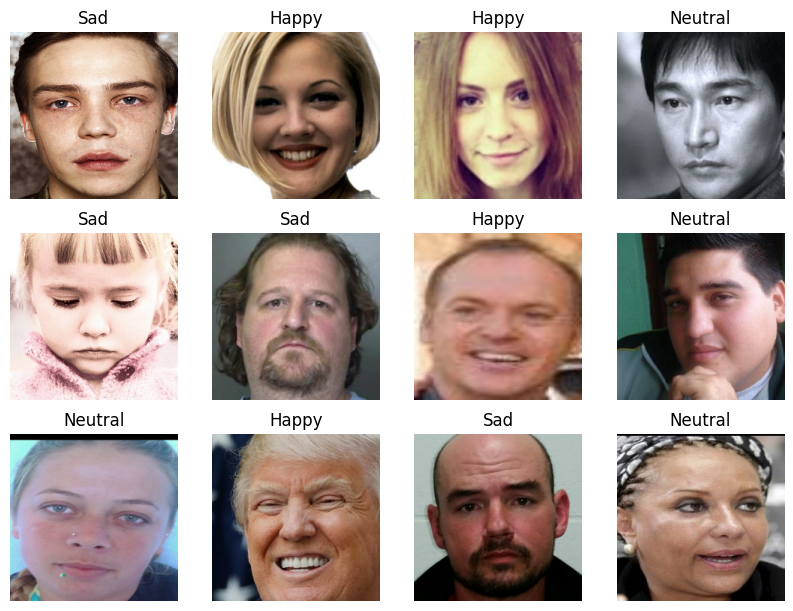

In [11]:
class_names = train_dataset.class_names

plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### show data samples

In [12]:
def total_sample(directory):
  total = 0
  for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder)
    total += len(os.listdir(folder_path))

  return total

train_sample_length = total_sample(train_dir)
validation_sample_length = total_sample(validation_dir)
print(f"The train directory has {train_sample_length} samples")
print(f"The validation directory has {validation_sample_length} samples")
print(f"Which in total makes it {train_sample_length + validation_sample_length} samples")

The train directory has 9360 samples
The validation directory has 2341 samples
Which in total makes it 11701 samples


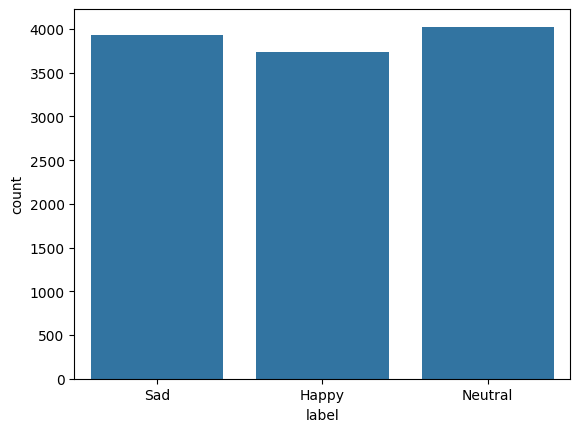

In [13]:
df = pd.read_csv('/content/emotion-recognition-dataset/data.csv')

select_label = ['Happy', 'Neutral', 'Sad']
df = df[df['label'].isin(select_label)]

sns.countplot(x = df['label'])
plt.xticks(rotation = 0)

plt.show()

# Preprocessing

### configure dataset performance

In [69]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

### implement data augmentation

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomZoom(width_factor=0.2, height_factor=0.2),
    tf.keras.layers.RandomWidth(factor=0.2),
    tf.keras.layers.RandomHeight(factor=0.2),
    tf.keras.layers.RandomBrightness(factor=0.1)
])

### visualize data augmentation

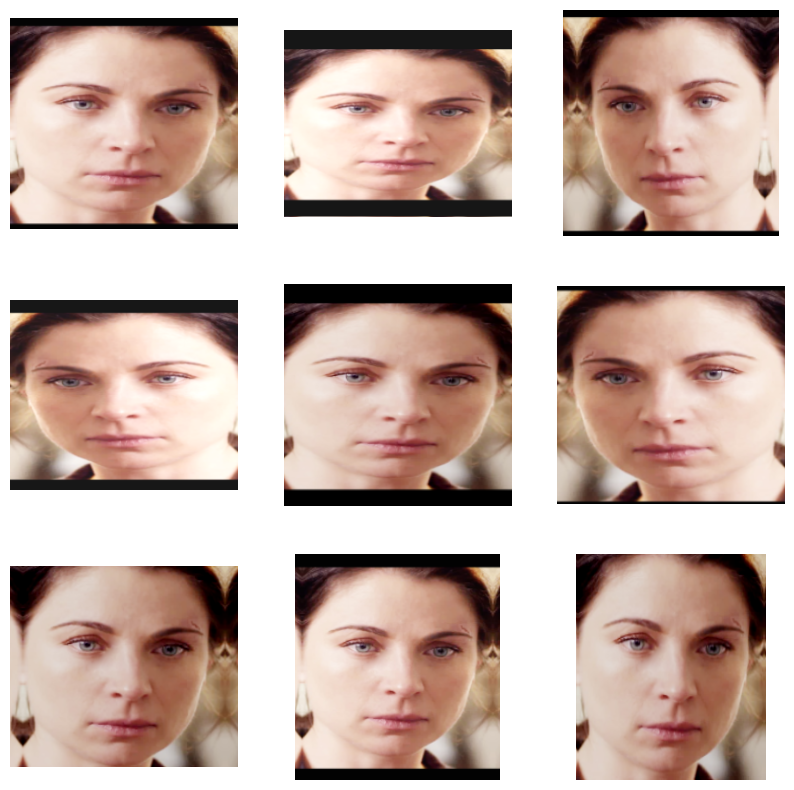

In [16]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### rescale pixel values

In [56]:
rescale = tf.keras.layers.Rescaling(1./255)

# Model Creation

### callback functions

In [18]:
class SudahWoi(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') >= 0.92 and logs.get('val_accuracy') >= 0.92:
      print(f"The model accuracy has reached 92%, stopping training")
      self.model.stop_training = True

model_complete = SudahWoi()

In [19]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("my_model_{val_accuracy:.2f}.h5", monitor="val_accuracy", verbose=0, mode="max", save_best_only=True)

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True, verbose=1)

In [21]:
class LearningRateLogger(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print(f"Epoch {epoch+1}/{self.params['epochs']}, Learning Rate: {self.model.optimizer.lr.numpy()}")

log_lr = LearningRateLogger()

In [22]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    patience=3,
    factor=0.8,
    verbose=1,
    mode="max",
    min_lr=0.00001
)

### create base model

In [93]:
from tensorflow.keras.applications import MobileNetV2
IMG_SHAPE = IMG_SIZE + (3,)

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=IMG_SHAPE)
)

base_model.trainable = False

In [96]:
model = tf.keras.Sequential()
model.add(Input(shape=(IMG_SHAPE)))
model.add(data_augmentation)
model.add(rescale)
model.add(base_model)
model.add(Conv2D(32, (3,3), activation=tf.nn.relu))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(GlobalAveragePooling2D())
model.add(Dense(32, activation=tf.nn.relu))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(3, activation=tf.nn.softmax))

In [97]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling_1 (Rescaling)     multiple                  0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d_13 (Conv2D)          (None, None, None, 32)    368672    
                                                                 
 dropout_26 (Dropout)        (None, None, None, 32)    0         
                                                                 
 batch_normalization_30 (Ba  (None, None, None, 32)    128       
 tchNormalization)                                   

In [98]:
int_lr = 1e-3
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=int_lr),
    loss = "sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [99]:
initial_epochs = 20

loss0, acc0 = model.evaluate(validation_dataset)

37/37 [==============================] - 12s 212ms/step - loss: 1.6206 - accuracy: 0.3340


In [100]:
modelku = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    callbacks=[early_stopping, model_complete, checkpoint],
    verbose=2
)

Epoch 1/20
147/147 - 56s - loss: 0.9717 - accuracy: 0.5322 - val_loss: 0.7913 - val_accuracy: 0.6326 - 56s/epoch - 379ms/step
Epoch 2/20
147/147 - 55s - loss: 0.7920 - accuracy: 0.6292 - val_loss: 0.7493 - val_accuracy: 0.6813 - 55s/epoch - 372ms/step
Epoch 3/20
147/147 - 49s - loss: 0.7391 - accuracy: 0.6609 - val_loss: 0.7012 - val_accuracy: 0.6830 - 49s/epoch - 336ms/step
Epoch 4/20
147/147 - 48s - loss: 0.7107 - accuracy: 0.6808 - val_loss: 0.7344 - val_accuracy: 0.6660 - 48s/epoch - 329ms/step
Epoch 5/20
147/147 - 52s - loss: 0.6817 - accuracy: 0.6926 - val_loss: 0.7164 - val_accuracy: 0.6728 - 52s/epoch - 353ms/step
Epoch 6/20
147/147 - 54s - loss: 0.6819 - accuracy: 0.6958 - val_loss: 0.6966 - val_accuracy: 0.6835 - 54s/epoch - 369ms/step
Epoch 7/20
147/147 - 50s - loss: 0.6562 - accuracy: 0.7064 - val_loss: 0.6651 - val_accuracy: 0.6993 - 50s/epoch - 339ms/step
Epoch 8/20
147/147 - 53s - loss: 0.6528 - accuracy: 0.7031 - val_loss: 0.6792 - val_accuracy: 0.6903 - 53s/epoch - 364

KeyboardInterrupt: 

### plot transfer learning

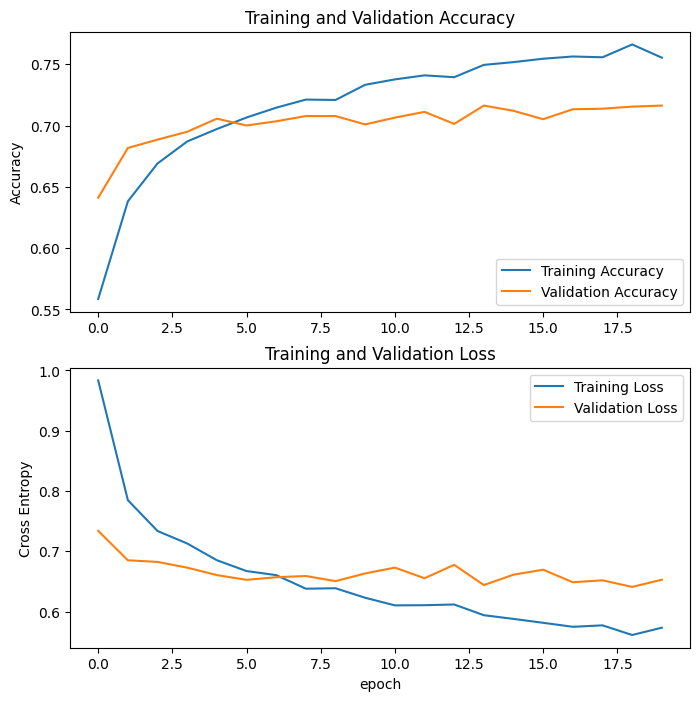

In [37]:
acc = modelku.history['accuracy']
val_acc = modelku.history['val_accuracy']

loss = modelku.history['loss']
val_loss = modelku.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning

In [38]:
base_model.trainable = True

In [39]:
print("Jumlah layer di base model: ", len(base_model.layers))

fine_tune_di = 100

for layer in base_model.layers[:fine_tune_di]:
  layer.trainable = False

Jumlah layer di base model:  154


In [46]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=int_lr/10, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [41]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling (Rescaling)       (None, None, None, 3)     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 batch_normalization_15 (Ba  (None, None, None, 1280   5120      
 tchNormalization)           )                                   
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 64)    737344    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, None, None, 64)   

In [47]:
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

modelku_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=modelku.epoch[-1],
    validation_data=validation_dataset,
    verbose=2,
    callbacks=[early_stopping, reduce_lr, log_lr, model_complete, checkpoint]
)

Epoch 20/40
Epoch 20/40, Learning Rate: 9.999999747378752e-05


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


293/293 - 56s - loss: 0.3594 - accuracy: 0.8644 - val_loss: 0.4149 - val_accuracy: 0.8232 - lr: 1.0000e-04 - 56s/epoch - 190ms/step
Epoch 21/40
Epoch 21/40, Learning Rate: 9.999999747378752e-05
293/293 - 43s - loss: 0.3305 - accuracy: 0.8776 - val_loss: 0.6414 - val_accuracy: 0.7569 - lr: 1.0000e-04 - 43s/epoch - 146ms/step
Epoch 22/40
Epoch 22/40, Learning Rate: 9.999999747378752e-05
293/293 - 47s - loss: 0.3161 - accuracy: 0.8839 - val_loss: 0.4475 - val_accuracy: 0.8150 - lr: 1.0000e-04 - 47s/epoch - 161ms/step
Epoch 23/40

Epoch 23: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
Epoch 23/40, Learning Rate: 7.999999797903001e-05
293/293 - 45s - loss: 0.2727 - accuracy: 0.9036 - val_loss: 0.5285 - val_accuracy: 0.7924 - lr: 1.0000e-04 - 45s/epoch - 154ms/step
Epoch 24/40
Epoch 24/40, Learning Rate: 7.999999797903001e-05
293/293 - 44s - loss: 0.2555 - accuracy: 0.9123 - val_loss: 0.5951 - val_accuracy: 0.7839 - lr: 8.0000e-05 - 44s/epoch - 149ms/step
Epoch 25/40
Ep

### plot fine tuning

In [43]:
acc += modelku_fine.history['accuracy']
val_acc += modelku_fine.history['val_accuracy']

loss += modelku_fine.history['loss']
val_loss += modelku_fine.history['val_loss']

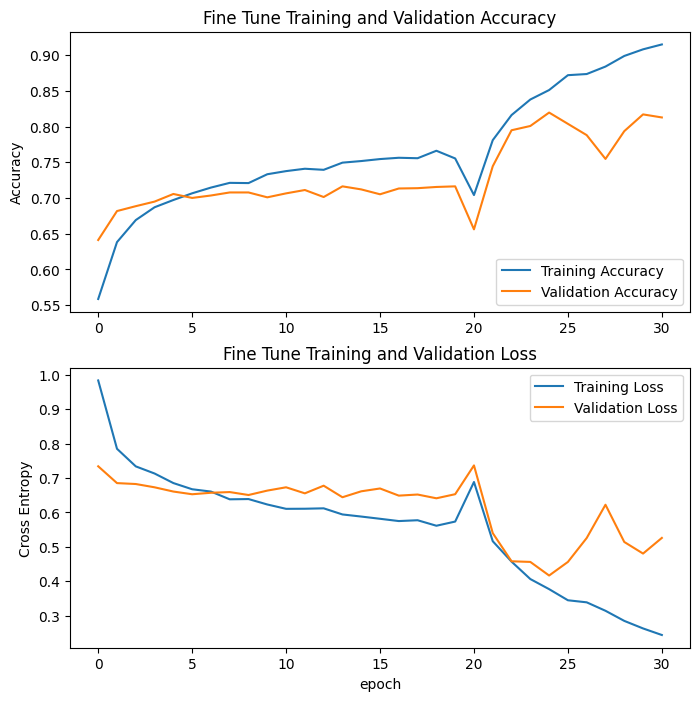

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Fine Tune Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Fine Tune Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Model Evaluation

In [45]:
loss, accuracy = model.evaluate(validation_dataset)
print('Validation accuracy :', accuracy)

74/74 [==============================] - 9s 108ms/step - loss: 0.4167 - accuracy: 0.8197
Validation accuracy : 0.8197351694107056


### predict image

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

class_labels = ['Happy', 'Neutral', 'Sad']

fig , axs = plt.subplots(1, len(uploaded), figsize=(15,5))

for i, fn in enumerate(uploaded.keys()):

  #predict gambar
  path = fn
  img = image.load_img(path, target_size=IMG_SIZE)

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)
  predicted_index = np.argmax(classes)
  confidence_score = classes[0][predicted_index]

  predicted_label = class_labels[predicted_index]

  axs[i].imshow(img)
  axs[i].set_title(f"Predicted: {predicted_label}\nConfidence: {confidence_score:.2f}")
  axs[i].axis('off')

plt.show()

# Save Model

In [ ]:
# menyimpan model dalam format saved model
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)